In [16]:
from PIL.Image import Image
from scipy.spatial.distance import jaccard
%matplotlib inline
import numpy as np
import torch
import torchvision
from torch import nn
from PIL import Image
import d2l

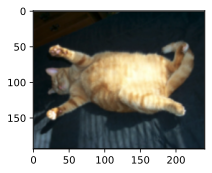

In [18]:
d2l.set_figsize()
img = Image.open("../img/cat1.png")
d2l.plt.imshow(img)

In [19]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

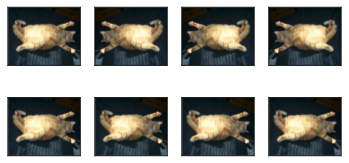

In [20]:
# 左右翻转图像通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。
# 随机翻转可以降低模型对镜像翻转的依赖。
apply(img, torchvision.transforms.RandomHorizontalFlip())

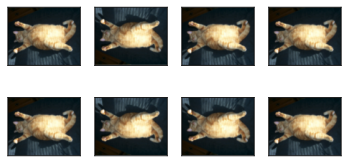

In [21]:
# 上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

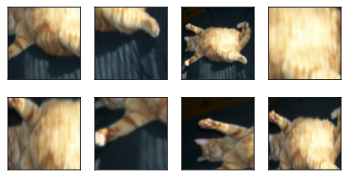

In [22]:
# 下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。然
# 后，区域的宽度和高度都被缩放到200像素
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

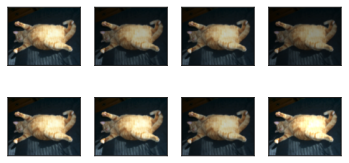

In [23]:
apply(img, torchvision.transforms.ColorJitter(
    # 分别对应亮度、对比度、饱和度、色调
    brightness=0.5, contrast=0, saturation=0, hue=0
))

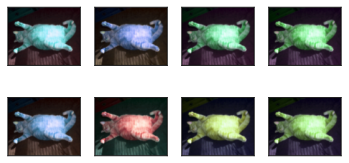

In [27]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))

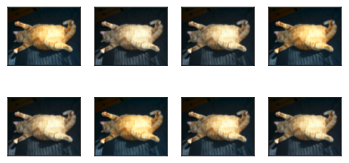

In [30]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0.5, hue=0
))

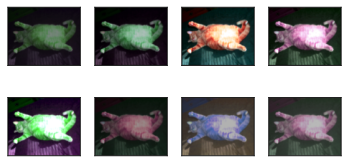

In [35]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

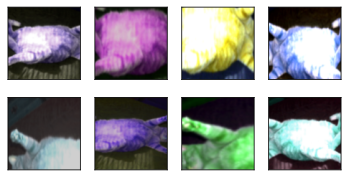

In [37]:
# 我们可以通过使用一个 Compose 实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug]
)
apply(img, augs)

100.0%


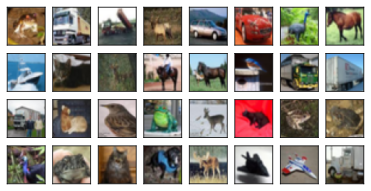

In [38]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [39]:
# 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
# 本次训练仅使用随机左右翻转的图像增广
# 此外，使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [40]:
# 定义一个辅助函数，便于读取图像和应用图像增广
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train, download=True, transform=augs)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers()
    )
    return dataloader

In [43]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

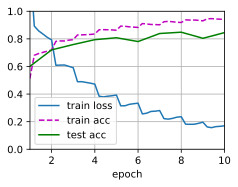

loss 0.170, train acc 0.941, test acc 0.845
2518.2 examples/sec on [device(type='mps', index=0)]


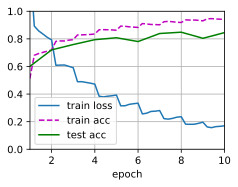

In [44]:
train_with_data_aug(train_augs, test_augs, net)

In [45]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
import d2l

In [47]:
d2l.DATA_HUB["hotdog"] = (d2l.DATA_URL + "hotdog.zip",
                                         "fba480ffa8aa7e0febbb511d181409f899b9baa5")

data_dir = d2l.download_extract("hotdog")

正在从http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip下载../../../data/hotdog.zip...


In [49]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

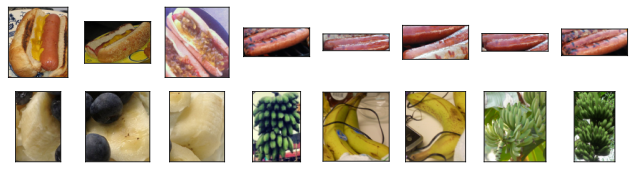

In [50]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [51]:
#在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为224 ×224输入图像。
#在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央224 ×224区域作为输入。
# 对于RGB（红、绿和蓝）颜色通道，我们分别正则化每个通道。这里预先计算并定义了这些魔数
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [58]:
# 下载 ImageNet 数据集上预训练的 ResNet-18 作为源模型
pretrained_net = torchvision.models.resnet18(pretrained=True)

In [59]:
# 预训练的源模型实例包含许多特征层和一个输出层fc，这样可以方便微调
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [60]:
# 接下来我们设置目标模型，注意输出结果只有“是热狗”和“不是”两个区别
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [67]:
# 定义微调训练函数
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, 'train'), transform=train_augs
        ),
        batch_size=batch_size, shuffle=True
    )
    test_iter = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            os.path.join(data_dir, 'test'), transform=test_augs
        ),
        batch_size=batch_size
    )
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                    {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(
            net.parameters(), lr=learning_rate, weight_decay=1e-3
        )
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

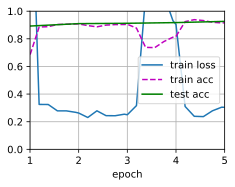

loss 0.304, train acc 0.916, test acc 0.926
529.2 examples/sec on [device(type='mps', index=0)]


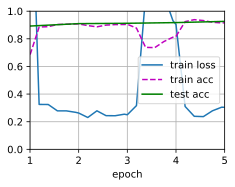

In [68]:
# 我们使用较小的学习率，通过微调预训练获得的模型参数
train_fine_tuning(finetune_net, 5e-5)

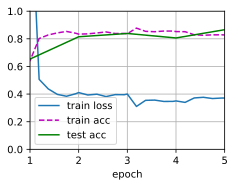

loss 0.371, train acc 0.828, test acc 0.866
628.1 examples/sec on [device(type='mps', index=0)]


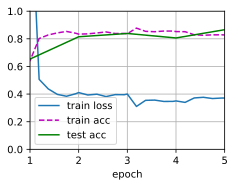

In [69]:
# 为了进行比较，我们定义了一个相同的模型，但是将其所有模型参数初始化为随机值。由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

In [70]:
%matplotlib inline
import torch
import d2l

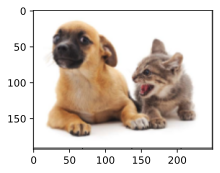

In [77]:
d2l.set_figsize()
img = d2l.plt.imread("../img/catdog.jpg")
d2l.plt.imshow(img)

In [72]:
"""
边界框有两种表示法
1. 由左上角和右下角坐标决定
2. 由边界框中心坐标及宽高决定
"""
def box_corner_to_center(boxes):
    """
    从 (左上,右下) 转换到 (中间,宽度,高度)
    """
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    cx = (x1+x2)/2
    cy = (y1+y2)/2
    w = x2-x1
    h = y2-y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """
    从(中间,宽度,高度) 转换到 (左上,右下)
    """
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [78]:
%matplotlib inline
import torch
import d2l

torch.set_printoptions(2) # 精简输出精度

In [101]:
def multibox_prior(data, sizes, ratios):
    """
    生成以每个像素为中心具有不同形状的锚框
    :param data: 二维特征图，代码中会根据其高度和宽度来确定锚框的生成范围
    :param sizes: 一个列表，包含了锚框的不同尺度的大小，取值范围为(0,1]
    :param ratios: 一个列表，包含了锚框的不同宽高比。
    """
    #data.shape 分别为(高,宽,通道数)
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    """
    为了将锚点移动到像素的中心，需要设置偏移量
    因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    """
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height # 在 y 轴上缩放步长
    steps_w = 1.0 / in_width # 在 x 轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # meshgrid 将两个一维向量 h,w 张成两个 len(h)*len(w) 的二维张量
    # 其中 shift_y 第 i 行的元素均为 h[i]，shift_x 第 i 行的元素均为 w[i]
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    # 在行方向上展开二维张量
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    """
    生成 "boxes_per_pixel" 个宽和高
    之后用于创建锚框的四角坐标(xmin, xmax, ymin, ymax)
    """
    w_0 = torch.cat((sizes[0] * torch.sqrt(in_height * ratio_tensor[:] / in_width),
                     size_tensor[1:] * torch.sqrt(in_height * ratio_tensor[0] / in_width)))
    h_0 = torch.cat((sizes[0] * torch.sqrt(in_width / ratio_tensor[:] / in_height),
                     size_tensor[1:] * torch.sqrt(in_width / ratio_tensor[0] / in_height)))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w_0, -h_0, w_0, h_0)).T.repeat(
        in_height * in_width, 1
    )/2

    """
    每个中心点都将有 "boxes_per_pixel" 个锚框
    所以生成含有所有锚框中心的网络，重复了 "boxes_per_pixel" 次
    """
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(
        boxes_per_pixel, dim=0
    )
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [102]:
img = d2l.plt.imread('../img/catdog.jpg')
h,w = img.shape[:2]
print(h,w)
X = torch.rand(size=(1,3,h,w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [103]:
# 我们访问以(250,250)为中心的第一个锚框。它有四个元素：
# 左上角(x,y)和右下角(x,y)
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.01, 0.02, 0.67, 0.87])

In [113]:
# 定义 show_bboxes 函数来在图像上绘制多个边界框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va="center", ha="center", fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

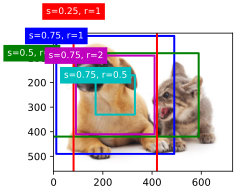

In [107]:
# 如上面结果所示，变量 boxes 中 x 轴和 y 轴的坐标值已经分别除以图像的宽度和高度
# 因此在绘制锚框时，我们需要恢复它们原始的坐标值。
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

In [117]:
# 两个边框的交并比
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    # 计算矩形面积。两集并的面积等于其面积之和减去其交的面积
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0] * (boxes[:, 3] - boxes[:, 1])))

    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    """
    在PyTorch中，None用于在指定位置插入一个新的维度。这里在第二个维度上插入一个新维度，
    使得 boxes1 的形状从 (N, 4) 变为 (N, 1, 4)

    当执行 torch.max(boxes1[:, None, :2], boxes2[:, :2])时，PyTorch就会使用广播机制。
    由于 boxes1[:, None, :2]的形状是(N, 1, 2)，boxes2[:,:2]的形状是(M,2)，广播后它们的
    形状会变为(N, M, 2)。
    这样就可以实现 boxes1 中的每个框与 boxes2 中的每个框两两组合，逐元素取最大值，从而得到每对
    框交集区域的左上角坐标
    """
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状：(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = area1[:, None] + area2 - inter_areas
    return inter_areas / union_areas

In [120]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第 i 行和第 j 列第元素 x_ij 是锚框 i 和 真实边界框 j 的 IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)

    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1) # 对列求最大值
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,),-1)
    row_discard = torch.full((num_gt_boxes,),-1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard

    return anchors_bbox_map

In [110]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], dim=1)
    return offset

In [122]:
# 如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为背景（background）。
# 背景类别的锚框通常被称为负类锚框，其余的被称为正类锚框。
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device
        )
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # 使用真实边界框来标记锚框的类别
        # 如果一个锚框没有被分配，标记其为背景(值为零)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    batch_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return bbox_offset, batch_mask, class_labels

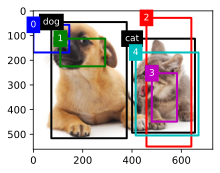

In [123]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                            [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])


fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

In [124]:
# 计算 IoU
labels = multibox_target(anchors.unsqueeze(dim=0),
                        ground_truth.unsqueeze(dim=0))

In [125]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [126]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = [] # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                    boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
        return torch.tensor(keep, device=boxes.device)

In [127]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                                conf.unsqueeze(1),
                                predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [153]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4, # 背景的预测概率
                        [0.9, 0.8, 0.7, 0.1], # 狗的预测概率
                        [0.1, 0.2, 0.3, 0.9]]) # 猫的预测概率

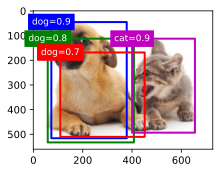

In [154]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9','dog=0.8','dog=0.7','cat=0.9'])

In [158]:
# 现在调用 multibox_detection函数来执行非极大值抑制，其中阈值设置为0.5
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)

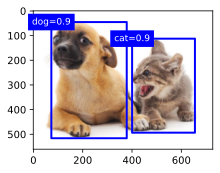

In [159]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In [160]:
%matplotlib inline
import torch
import d2l

img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
h, w

(561, 728)

In [166]:
def display_anchors(fmap_w, fmap_h, s):
    """
    我们在特征图(fmap)上生成锚框(anchors)，每个单位（像素）作为锚框的中心
    对像素均匀采样 fmap_w * fmap_h 个点，并生成大小为 s 且宽高比(ratios)不同的锚框
    """
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

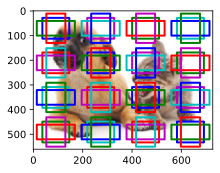

In [164]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

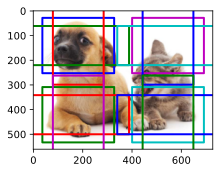

In [165]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

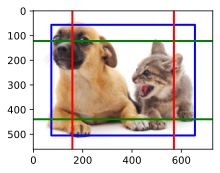

In [167]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

In [3]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
import d2l

In [4]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [5]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                            else 'bananas_val','label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                        'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [6]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
        is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [7]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                            batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                            batch_size)
    return train_iter, val_iter

In [8]:
"""
图像的小批量的形状为(批量大小,通道数,高度,宽度)
标签的小批量的形状为(批量大小,m,5)
其中 m 是数据集中任何图像的边界框可能出现的最大数量。如果一个图像边界框不足 m，将会被非法边界框填充
这样，每个边界框的标签将被长度为5的数组表示。其中第一个元素是边界框中对象的类别，其中-1用于表示填充的非法边界框
剩下四个元素分别是边界框左上角和右下角的(x,y)坐标值（值域在0～1之间）
"""
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

正在从http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip下载../../../data/banana-detection.zip...
read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

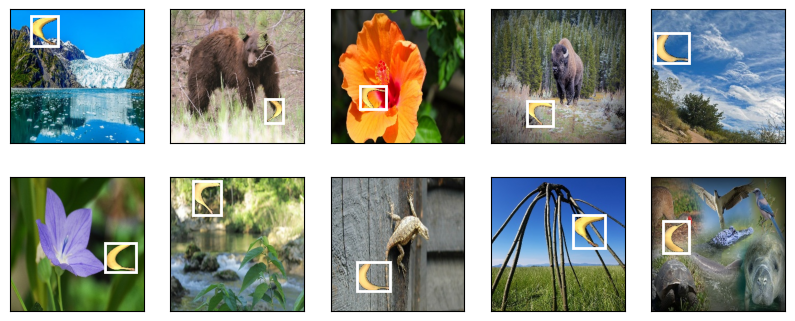

In [9]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

In [10]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                    kernel_size=3, padding=1)

In [11]:
# 边界框预测层的设计与类别预测层的设计类似。唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是q + 1个类别。
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [12]:
# 单发多框检测使用多尺度特征图来生成锚框并预测其类别和偏移量
# 在不同尺度下，特征图的形状可能有所不同。因此，预测输出的情状也可能会有所不同

"""
下面示例中，我们为同一个小批量构建两个不同比例(Y1和Y2)的特征图，其中Y2的高度和宽度是Y1的一半
假设Y1和Y2的每个单元生成5个和3个锚框，进一步假设目标类别的数量为10
对于Y1和Y2，类别预测输出的通道数为 55 和 33，输出形状为(批量大小,通道数,高度,宽度)
"""
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [13]:
"""
正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。
为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。
因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高×宽×通道数）的格式，以方便之后在维度1上的连结。
"""
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [14]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [15]:
"""
为了在多个尺度下检测目标，我们在下面定义了高和宽减半块down_sample_blk，该模块将输入特征图的高度和宽度减半。
更具体地说，每个高和宽减半块由两个填充为1的3*3的卷积层、以及步幅为2的2*2最大汇聚层组成。
"""
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
        kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [16]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [17]:
# 多尺度检测的基本网络块用于从输入图像中抽取特征。
# 为了计算简洁，该网络串联3个高宽减半块，并逐步将通道数翻倍
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [18]:
"""
完整的单发多框检测模型由五个模块组成。除了最开始的基本模块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池讲高度和宽度都降到1
"""
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [19]:
"""
不同于图像分类问题，图像检测的输出包括：CNN特征图y；当前尺度下根据y生成的锚框；预测的这些锚框的类别和偏移量（基于Y）
"""
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [20]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [22]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))


    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
                            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [23]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [24]:
# 读取香蕉检测数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [25]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [26]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
# 对偏移量使用L1范数损失
bbox_loss = nn.L1Loss(reduction='none')

# 掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                    cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                    bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [27]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
                  cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

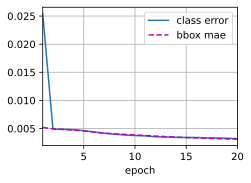

class err 3.19e-03, bbox mae 3.10e-03
10003.2 examples/sec on mps:0


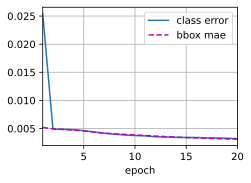

In [28]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error','bbox mae'])
net = net.to(device)


for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                        bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                    bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                    bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
        f'{str(device)}')

In [29]:
X = torchvision.io.read_image('../img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [30]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    # 通过非极大值抑制来移除相似的预测边界框
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

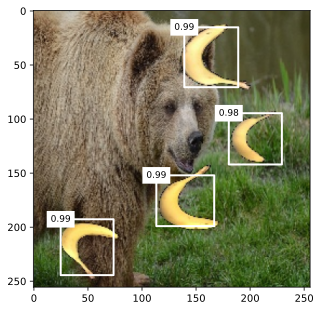

In [31]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')


display(img, output.cpu(), threshold=0.9)